# Application of a Trained Model

In this tutorial we will show you how to use a trained model to make predictions for a new set of compounds. As an example, we will take the model trained in "**Tutorial 3: Train a Simple Regression Model**", which predicts $pK_i$ values for inhibition of SLC6A3, and apply it to the test subset compounds from the original training dataset. Since we know the actual $pK_i$ values for these compounds, we will then plot the predicted values against the actual values to see how well the model performs on this compound set. 

This tutorial focuses on these **[AMPL](https://github.com/ATOMScience-org/AMPL)** functions:

* [predict_from_model_file](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.predict_from_model.predict_from_model_file)
* [plot_pred_vs_actual_from_df](https://ampl.readthedocs.io/en/latest/pipeline.html#pipeline.perf_plots.plot_pred_vs_actual_from_df)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ignore sklearn future warnings
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from atomsci.ddm.pipeline import predict_from_model as pfm
from sklearn.metrics import r2_score

Skipped loading some Jax models, missing a dependency. No module named 'haiku'
/opt/anaconda3/envs/atom-dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Creating The Test Dataset
First, create a test set by selecting the test data from the curated dataset.
Here we are using the pre-featurized dataset to save time.

In [2]:
split_file_path = 'dataset/SLC6A3_Ki_curated_train_valid_test_scaffold_c35aeaab-910c-4dcf-8f9f-04b55179aa1a.csv'
curated_data_path = 'dataset/scaled_descriptors/SLC6A3_Ki_curated_with_rdkit_raw_descriptors.csv'

split_data = pd.read_csv(split_file_path)

curated_data = pd.read_csv(curated_data_path)

test_ids=split_data[split_data.subset == 'test'].cmpd_id.unique()
test_data = curated_data[curated_data.compound_id.isin(test_ids)]

# show most useful columns 
test_data[['compound_id', 'base_rdkit_smiles', 'avg_pKi']].head()

,compound_id,base_rdkit_smiles,avg_pKi
3,CHEMBL17157,CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...,6.692504
7,CHEMBL3321789,OC1(c2ccc(Cl)cc2)CC2CCC(C1)N2CCCOc1ccc(F)cc1,6.207608
13,CHEMBL595638,CN1C2CCC1[C@@H](C(=O)OCc1cn(CCOC(=O)[C@H]3C4CC...,7.795880
28,CHEMBL4447975,COc1cc(OC)c2c(c1)OC[C@@]1(C)NCC[C@@H]21,5.000000
41,CHEMBL1062,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@...,5.260744


## Performing Predictions
Next, load a pretrained model from a model tarball file and run 
predictions on compounds in the test set. If the original model 
`response_col` was `avg_pKi`, the returned data frame will 
contain columns `avg_pKi_actual`, `avg_pKi_pred`, and 
`avg_pKi_std`. The predictions of $pK_i$ are in the column, 
`avg_pKi_pred`. The `avg_pKi_std` column contains uncertainity estimates (standard deviations) for the predictions.

Here we set the `is_featurized` parameter to true, since we're using
the pre-featurized dataset.

> **Note:** *For the purposes of this tutorial, the following model has been altered to work on every file system. In general, to run a model that was trained on a different machine, you need to provide the path to the local copy of the training dataset as an additional parameter called `external_training_data`.*

In [3]:
model_dir = 'dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9ff5a924-ef49-407c-a4d4-868a1288a67e.tar.gz'
input_df = test_data
id_col = 'compound_id'
smiles_col = 'base_rdkit_smiles'
response_col = 'avg_pKi'

# loads a pretrained model from a model tarball file and runs predictions on 
# compounds in an input data frame
pred_df = pfm.predict_from_model_file(model_path = model_dir, 
                                      input_df = test_data,
                                      id_col = id_col ,
                                      smiles_col = smiles_col, 
                                      response_col = response_col,
                                      is_featurized=True)
                                      

# show most useful columns
pred_df[['compound_id', 'base_rdkit_smiles', 'avg_pKi_actual','avg_pKi_pred', 'avg_pKi_std']].head()

Standardizing SMILES strings for 273 compounds.


INFO:atomsci.ddm.utils.model_version_utils:dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9ff5a924-ef49-407c-a4d4-868a1288a67e.tar.gz, 1.6.1
INFO:atomsci.ddm.utils.model_version_utils:Version compatible check: dataset/SLC6A3_models/SLC6A3_Ki_curated_model_9ff5a924-ef49-407c-a4d4-868a1288a67e.tar.gz version = "1.6", AMPL version = "1.6"
/Users/rwilfong/Downloads/2024_LLNL/fork_ampl/AMPL/atomsci/ddm/pipeline/transformations.py:250: RuntimeWarning: invalid value encountered in divide
  X = np.nan_to_num((X - self.X_means) * X_weight / self.X_stds)


,compound_id,base_rdkit_smiles,avg_pKi_actual,avg_pKi_pred,avg_pKi_std
0,CHEMBL17157,CC(C)(C)c1ccc(C(O)CCCN2CCC(C(O)(c3ccccc3)c3ccc...,6.692504,7.741641,1.289527
1,CHEMBL3321789,OC1(c2ccc(Cl)cc2)CC2CCC(C1)N2CCCOc1ccc(F)cc1,6.207608,6.607851,1.069817
2,CHEMBL595638,CN1C2CCC1[C@@H](C(=O)OCc1cn(CCOC(=O)[C@H]3C4CC...,7.795880,6.784137,1.271238
3,CHEMBL4447975,COc1cc(OC)c2c(c1)OC[C@@]1(C)NCC[C@@H]21,5.000000,6.080245,1.321997
4,CHEMBL1062,CC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@...,5.260744,6.304104,1.517846


## Evaluating Prediction Performance
Then, calculate the $R^2$ score and compare it with the expected test $R^2$
score of 0.426594, reported in **Tutorial 3, "Train a Simple Regression Model"**.

In [4]:
actual_value = pred_df['avg_pKi_actual']
predicted_value = pred_df['avg_pKi_pred']
r2 = np.round(r2_score(actual_value, predicted_value), 6)
r2

0.426594

## Visualizing Prediction Results
We can visualize the results in a scatter plot of predicted values vs. actual values. 

In [5]:
from atomsci.ddm.pipeline import perf_plots as pp

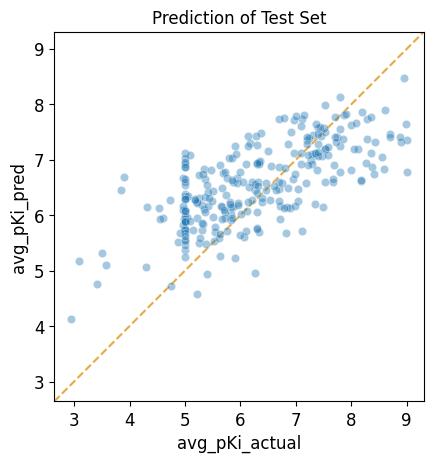

In [6]:
# Plots predicted vs actual values from a trained regression model for a given 
# dataframe
pp.plot_pred_vs_actual_from_df(pred_df, 
                               actual_col='avg_pKi_actual', 
                               pred_col='avg_pKi_pred', 
                               label='Prediction of Test Set');

In **Tutorial 5, "Hyperparameter Optimization"**, we will move beyond a single model and learn to optimize model hyperparameters by training many models.

If you have specific feedback about a tutorial, please complete the **[AMPL Tutorial Evaluation](https://forms.gle/pa9sHj4MHbS5zG7A6)**.